In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
from scipy.special import expit
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import normalize
from sklearn.metrics import log_loss
from sklearn.datasets import load_digits
plt.rcParams['figure.figsize'] = [12, 10]

In [2]:
def convert_labels(y):
    y = np.where(y<5, 0, y)
    return np.where(y>4, 1, y)

def sigmoid(x):
    return expit(x)

def bound(x):
    x = np.where(x<1e-16,1e-16,x)
    return np.where(x>1-(1e-16), (1-1e-16), x)

def Predict(x,w,b):
    pred = bound(sigmoid(x@w+b))
    pred = np.where(pred>0.5, 1, pred)
    return np.where(pred<=0.5, 0 ,pred)

def Logistic_Regression_Batch_GD(x, y, eta, K):
    #Initialize weights and bias
    b = 0.1
    w = np.zeros([x.shape[1],1])
    n = len(x)
    
    costs = []
    y = y.reshape((len(y),1))
    
    #For each iteration
    for k in tqdm(range(K)):
        
        #Make prediction
        y_pred = bound(sigmoid(x@w+b))
        
        #Update weights
        w = w - eta*(x.T@(y_pred-y)/n)
        b = b - eta*np.sum(y_pred-y)
        
        #Compute cost
        costs += [log_loss(y, y_pred)]
        
    return w, b, np.array(costs)

def Logistic_Regression_SGD(x, y, eta, K):
    #Initialize weights and bias
    b = 0.1
    w = np.zeros([x.shape[1],1])
    
    costs = []
    y = y.reshape((len(y),1))
    
    #For each iteration
    for k in tqdm(range(K)):
        
        #Draw random sample with replacement
        idx = np.random.randint(0,len(x))
        xx = x[idx]
        yy = y[idx]
        
        #Fixed learning rate
        a = eta
        #a = eta/np.sqrt(k+1)
        
        #Make prediction
        y_pred = bound(sigmoid(xx@w+b))

        #Update weights
        grad = (xx*(y_pred-yy)).reshape((64,1))
        w = w - a*grad
        b = b - a*(y_pred-yy)

        #Compute cost
        pred = bound(sigmoid(x@w+b))
        costs += [log_loss(y, pred, labels = [0,1])]
        
    return w, b, np.array(costs)

def Logistic_Regression_GA(x, y, eta, K):
    #Initialize weights and bias
    b = 0.1
    w = np.zeros([x.shape[1],1])
    g = 0
    
    costs = []
    y = y.reshape((len(y),1))
    
    #For each iteration
    for k in tqdm(range(K)):
        
        #Draw random sample with replacement
        idx = np.random.randint(0,len(x))
        xx = x[idx]
        yy = y[idx]
        
        #Fixed learning rate
        a = eta
        #a = eta/np.sqrt(k+1)
        
        #Make prediction
        y_pred = bound(sigmoid(xx@w+b))

        #Update weights
        n = k+1
        grad = (xx*(y_pred-yy)).reshape((64,1))
 
        w = w - a*(g/n)
        b = b - a*(y_pred-yy)
        
        g += grad

        #Compute cost
        pred = bound(sigmoid(x@w+b))
        costs += [log_loss(y, pred, labels = [0,1])]
        
    return w, b, np.array(costs)

def Logistic_Regression_SAG(x, y, eta, K):
    #Initialize weights and bias
    b = 0.1
    w = np.zeros([x.shape[1],1])
    g = 0
    g_prev = 0
    table = 0
    
    costs = []
    y = y.reshape((len(y),1))
    
    #For each iteration
    for k in tqdm(range(K)):
        
        #Draw random sample with replacement
        idx = np.random.randint(0,len(x))
        xx = x[idx]
        yy = y[idx]
        
        #Fixed learning rate
        a = eta
        #a = eta/np.sqrt(k+1)
        
        #Make prediction
        y_pred = bound(sigmoid(xx@w+b))

        #Update weights
        n = k+1
        grad = (xx*(y_pred-yy)).reshape((64,1))
 
        w = w - a*(grad + g/n)
        b = b - a*(y_pred-yy)
        
        g += grad
        g_prev = grad

        #Compute cost
        pred = bound(sigmoid(x@w+b))
        costs += [log_loss(y, pred, labels = [0,1])]
        
    return w, b, np.array(costs)

In [3]:
#Load data and split train and test
digits = load_digits()
X = digits.data
y = convert_labels(digits.target).reshape(len(digits.target),1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [4]:
#Train
w,b,costs = Logistic_Regression_Batch_GD(X_train, y_train, eta=0.001, K=10000)
w2,b2,costs2 = Logistic_Regression_SGD(X_train, y_train, eta=0.0001, K=10000)
w3,b3,costs3 = Logistic_Regression_GA(X_train, y_train, eta=0.0001, K=10000)
w4,b4,costs4 = Logistic_Regression_SAG(X_train, y_train, eta=0.0001, K=10000)

#Test
y_pred = Predict(X_test,w,b)
y_pred2 = Predict(X_test,w2,b2)
y_pred3 = Predict(X_test,w3,b3)
y_pred4 = Predict(X_test,w4,b4)
#Accuracies
print("Test Accuracy for batch GD:", accuracy_score(y_test, y_pred))
print("Test Accuracy for SGD:", accuracy_score(y_test, y_pred2))
print("Test Accuracy for GA:", accuracy_score(y_test, y_pred3))
print("Test Accuracy for SAG:", accuracy_score(y_test, y_pred4))

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1785.18it/s]

Test Accuracy for batch GD: 0.8733333333333333
Test Accuracy for SGD: 0.8822222222222222
Test Accuracy for GA: 0.8733333333333333
Test Accuracy for SAG: 0.8755555555555555


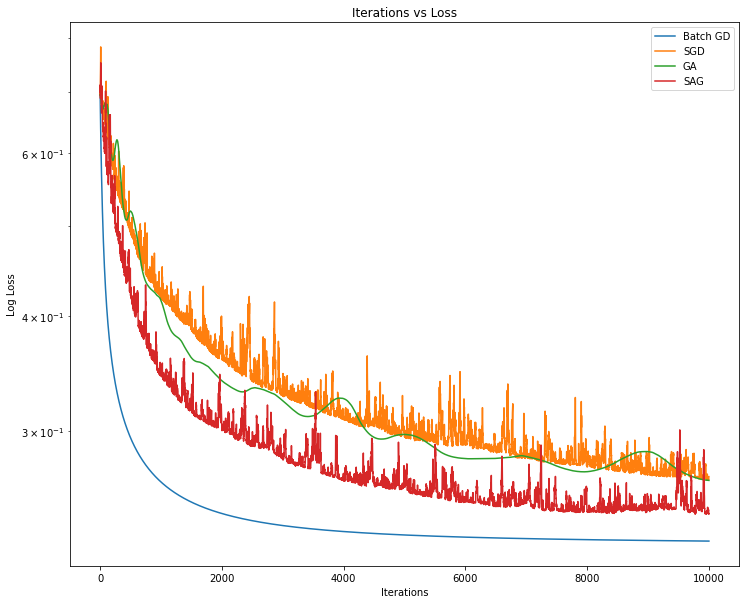

In [5]:
#Plots
plt.plot(np.arange(len(costs)),costs, label="Batch GD")
plt.plot(np.arange(len(costs2)),costs2, label="SGD")
plt.plot(np.arange(len(costs3)),costs3, label="GA")
plt.plot(np.arange(len(costs4)),costs4, label="SAG")

plt.xlabel("Iterations")
plt.ylabel("Log Loss")
plt.title("Iterations vs Loss")
plt.legend()
plt.yscale("log");

In [6]:
# w1,b1,costs1 = Logistic_Regression_SGD(X_train, y_train, eta=0.0001, K=3000)
# w2,b2,costs2 = Logistic_Regression_SGD(X_train, y_train, eta=0.00001, K=3000)
# w3,b3,costs3 = Logistic_Regression_SGD(X_train, y_train, eta=0.000001, K=3000)
# plt.plot(np.arange(len(costs1)),costs1)
# plt.plot(np.arange(len(costs2)),costs2)
# plt.plot(np.arange(len(costs3)),costs3)
# plt.yscale("log");

In [7]:
# def Logistic_Regression_Reg(x, y, eta, K, L):
#     b = 0.1
#     costs = []
#     w = np.zeros([x.shape[1],1])
#     y = y.reshape((len(y),1))
#     for k in tqdm(range(K)):
#         #make prediction
#         y_pred = bound(sigmoid(x@w+b))
        
#         #update weights
#         w = w - eta*(x.T@(y_pred-y)+2*L*w)
#         b = b - eta*np.sum(y_pred-y)
        
#         #compute cost
#         cost = -np.sum(y.T@np.log(y_pred) + (1-y).T@np.log(1-y_pred))/K
#         cost += L*(np.linalg.norm(w,2))**2
#         costs += [cost]
        
#     return w, b, np.array(costs)
    
    
# def Logistic_Regression_SGD(x, y, eta, epoch):
#     b = 0.1
#     costs = []
#     w = np.zeros([x.shape[1],1])
#     y = y.reshape((len(y),1))
#     for k in tqdm(range(epoch)):
#         np.random.seed(42)
#         idx = np.random.permutation(len(x))
#         xx = x[idx]
#         yy = y[idx]
#         #for each data point
#         for i in range(len(x)):
#             a = eta
#             #make prediction
#             y_pred = bound(sigmoid(xx[i]@w+b))
            
#             #update weights
#             grad = (xx[i]*(y_pred-yy[i])).reshape((64,1))
#             w = w - a*grad
#             b = b - a*(y_pred-yy[i])

#             #compute cost
#             costs += [log_loss(yy[i], y_pred, labels = [0,1])]
        
#     return w, b, np.array(costs)